# Vehicle Detection and Tracking

### Imports

In [1]:
import datetime
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.externals import joblib

from moviepy.editor import VideoFileClip, concatenate_videoclips, ImageSequenceClip
from IPython.display import HTML

# Python module containing code for scanning windows, classification and heatmap generation
exec(open("./vehicleScan.py").read())

# Python module for feature extraction functions
from mylib import extract_features, get_hog_features

## Training the Model

In [2]:
# Extract the Features

# Read in car and non-car images
# Extract vehicles and non-Vehicles dataset into directory train
ext = 'png'
car_images = [glob.glob('./train/cars/GTI_Far/*.'+ext), glob.glob('./train/cars/GTI_Left/*.'+ext),
              glob.glob('./train/cars/GTI_MiddleClose/*.'+ext), glob.glob('./train/cars/GTI_Right/*.'+ext),
              glob.glob('./train/cars/KITTI_extracted/*.'+ext),]
notcar_images = [glob.glob('./train/notcars/Extras/*.'+ext), glob.glob('./train/notcars/GTI/*.'+ext)]
cars = []
notcars = []
for image_dir in car_images:
    for image in image_dir:
        cars.append(image)
for image_dir in notcar_images:
    for image in image_dir:
        notcars.append(image)

# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 16
histbin = 32
color_space = 'LUV'
orient = 11
pix_per_cell = 8
cell_per_block = 2
print("Extracting features..")
t0=time.time()
car_features = extract_features(cars, cspace=color_space, spatial_size=(spatial, spatial), include_hist=True,
                        hist_bins=histbin, hist_range=(0, 256),include_hog=True, include_spatial=True,
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, feature_vec=True)
notcar_features = extract_features(notcars, cspace=color_space, spatial_size=(spatial, spatial), include_hist=True,
                        hist_bins=histbin, hist_range=(0, 256),include_hog=True, include_spatial=True,
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, feature_vec=True)
t1=time.time()
print(round(t1-t0, 2), 'Seconds to extract features')
print(len(car_features), len(notcar_features))
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print(len(X), len(y))

Extracting features..
39.52 Seconds to extract features
8792 8968
17760 17760


In [5]:
# Training the Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)#, random_state=rand_state)
print(X_train.shape)
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
print("Training..")
# Use a rbf kernel SVC 
svc = SVC(C=10)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = len(y_test)
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 2), 'Seconds to predict', n_predict,'labels with SVC')

print("Saving the model..")
joblib.dump(svc, 'svm_model.pkl')
joblib.dump(X_scaler, 'svm_scaler.pkl')
print("Model saved.")

(15096, 3020)
Using spatial binning of: 16 and 32 histogram bins
Feature vector length: 3020
Training..
91.6 Seconds to train SVC...
Test Accuracy of SVC =  0.991
My SVC predicts:  [1. 0. 0. ... 1. 1. 0.]
For these 2664 labels:  [1. 0. 0. ... 1. 1. 0.]
14.97 Seconds to predict 2664 labels with SVC
Saving the model..
Model saved.


## HOG Features of image

Hog features of Car images while using LUV format.


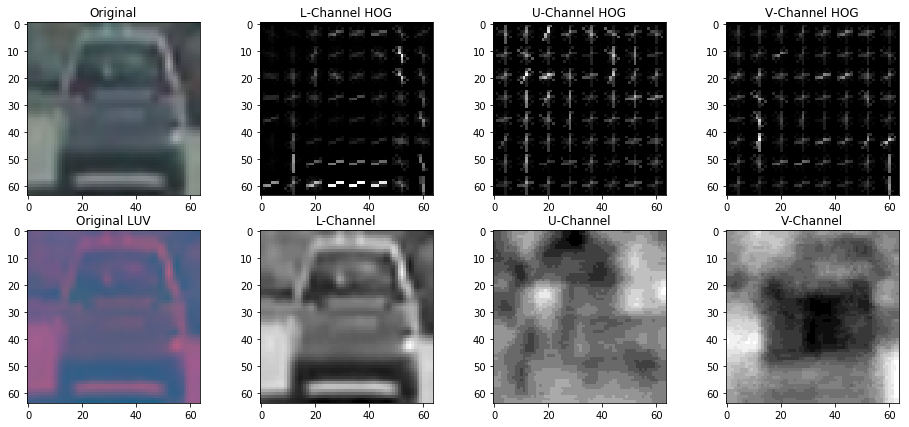

In [65]:
print("Hog features of Car images while using LUV format.")
fig = plt.figure(figsize=(16, 7))
fig.add_subplot(2, 4, 1)
img = cv2.cvtColor(cv2.imread(cars[5]), cv2.COLOR_BGR2RGB)
plt.title("Original")
plt.imshow(img)

feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2Luv)
hf, hfv_c1 = get_hog_features(feature_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
fig.add_subplot(2, 4, 2)
plt.title("L-Channel HOG")
plt.imshow(hfv_c1, cmap="gray")

hf, hfv_c2 = get_hog_features(feature_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
fig.add_subplot(2, 4, 3)
plt.title("U-Channel HOG")
plt.imshow(hfv_c2, cmap="gray")

hf, hfv_c3 = get_hog_features(feature_image[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
fig.add_subplot(2, 4, 4)
plt.title("V-Channel HOG")
plt.imshow(hfv_c3, cmap="gray")

fig.add_subplot(2, 4, 5)
plt.title("Original LUV")
plt.imshow(feature_image)
fig.add_subplot(2, 4, 6)
plt.title("L-Channel")
plt.imshow(feature_image[:,:,0], cmap="gray")
fig.add_subplot(2, 4, 7)
plt.title("U-Channel")
plt.imshow(feature_image[:,:,1], cmap="gray")
fig.add_subplot(2, 4, 8)
plt.title("V-Channel")
plt.imshow(feature_image[:,:,2], cmap="gray")
plt.show()

From images above it is visible that U and V channel do not carry much distinguishable information.

Hog features of Not-Car images while using LUV format.


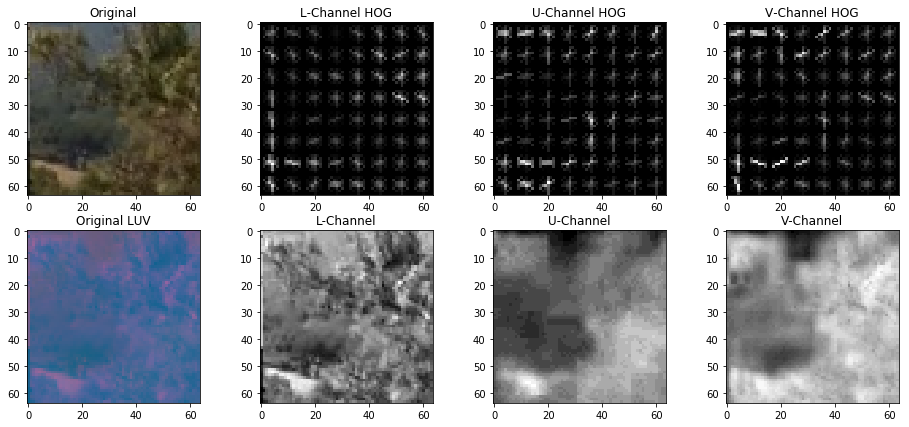

In [60]:
print("Hog features of Not-Car images while using LUV format.")
fig = plt.figure(figsize=(16, 7))
fig.add_subplot(2, 4, 1)
img = cv2.cvtColor(cv2.imread(notcars[1]), cv2.COLOR_BGR2RGB)
plt.title("Original")
plt.imshow(img)

feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2Luv)
hf, hfv_c1 = get_hog_features(feature_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
fig.add_subplot(2, 4, 2)
plt.title("L-Channel HOG")
plt.imshow(hfv_c1, cmap="gray")

hf, hfv_c2 = get_hog_features(feature_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
fig.add_subplot(2, 4, 3)
plt.title("U-Channel HOG")
plt.imshow(hfv_c2, cmap="gray")

hf, hfv_c3 = get_hog_features(feature_image[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
fig.add_subplot(2, 4, 4)
plt.title("V-Channel HOG")
plt.imshow(hfv_c3, cmap="gray")


fig.add_subplot(2, 4, 5)
plt.title("Original LUV")
plt.imshow(feature_image)
fig.add_subplot(2, 4, 6)
plt.title("L-Channel")
plt.imshow(feature_image[:,:,0], cmap="gray")
fig.add_subplot(2, 4, 7)
plt.title("U-Channel")
plt.imshow(feature_image[:,:,1], cmap="gray")
fig.add_subplot(2, 4, 8)
plt.title("V-Channel")
plt.imshow(feature_image[:,:,2], cmap="gray")
plt.show()

## Sliding Window Search

### Create Windows to scan

Original Image


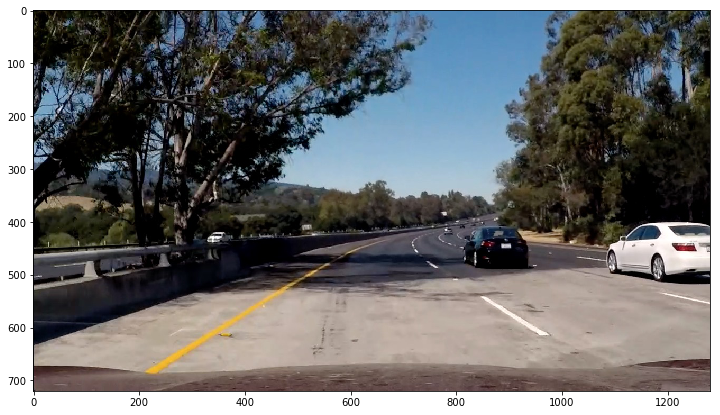

Original Image with Windows drawn over Region of Interest


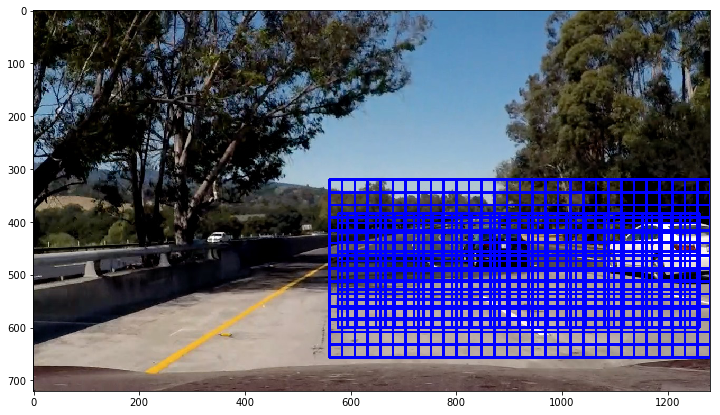

Frame dimensions (w x h): (1280, 720)
Created required Windows to scan.


In [2]:
# global variables for processing video
vid = "project"
# get fps and frame from the input video
output_vid = "./output_videos/"+vid+"_video.mp4"
in_clip = VideoFileClip(vid+"_video.mp4")
fps = in_clip.fps

# Read one frame into memory to get frame details
f_frame = None
for frame in in_clip.iter_frames():
    f_frame = frame
    break


# Processing metadata
proc_data={
    "orient" : 11,
    "pix_per_cell" : 8,
    "cell_per_block" : 2,
    "spatial" : 16,
    "hbins" : 32,
    "overlap" : 0.75,
    "inc_spatial" : True,
    "inc_hist" : True,
    # training image size
    "trained_win_size" : 64,
    # list of windows for each window size
    "windows" : {96: Window(), 72: Window()},
    "frame_height" : f_frame.shape[0],
    "frame_width" : f_frame.shape[1]
}

# Read in an image(only for display purpose)
image = cv2.imread('./test_images/test5.jpg')
image = cv2.resize(image, (proc_data["frame_width"], proc_data["frame_height"]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("Original Image")
plt.figure(figsize=(20, 7))
plt.imshow(image)
plt.show()


# vertical scanning area
y_fullrange_img = [((proc_data["frame_height"]//2)//64)*64, proc_data["frame_height"]-48]
# image scanning area height
y_len = y_fullrange_img[1] - y_fullrange_img[0]
# range_offsets along x-axis for each window
x_offset = {96:0, 72:16}    # format: {win_size: offset, ..}
# range_offsets along y-axis for each window
y_offset = {96:0, 72:64}

############## Create all the Windows in region of interest ##############
for win_size in proc_data["windows"]:
    proc_data["windows"][win_size].windows
    # scan range for y-axis
    y_range_img = [y_fullrange_img[0] + y_offset[win_size], y_fullrange_img[1] - y_offset[win_size]]
    # get x range for search
    x_range_img = [x_offset[win_size]+(7*proc_data["frame_width"]//16),
                   proc_data["frame_width"] - x_offset[win_size]]
    proc_data["windows"][win_size].windows = get_windows(image, x_start_stop=x_range_img, y_start_stop=y_range_img,
                                        xy_window=(win_size, win_size),
                                        xy_overlap=(proc_data["overlap"], proc_data["overlap"]), draw=True)
    proc_data["windows"][win_size].x_range_img = x_range_img
    proc_data["windows"][win_size].y_range_img = y_range_img

print("Original Image with Windows drawn over Region of Interest")
fig = plt.figure(figsize=(20, 7))
plt.imshow(image)
plt.show()
print("Frame dimensions (w x h):", (f_frame.shape[:2])[::-1])
print("Created required Windows to scan.")

Region of interest was selected to ease processing.

### Search for Cars in created windows

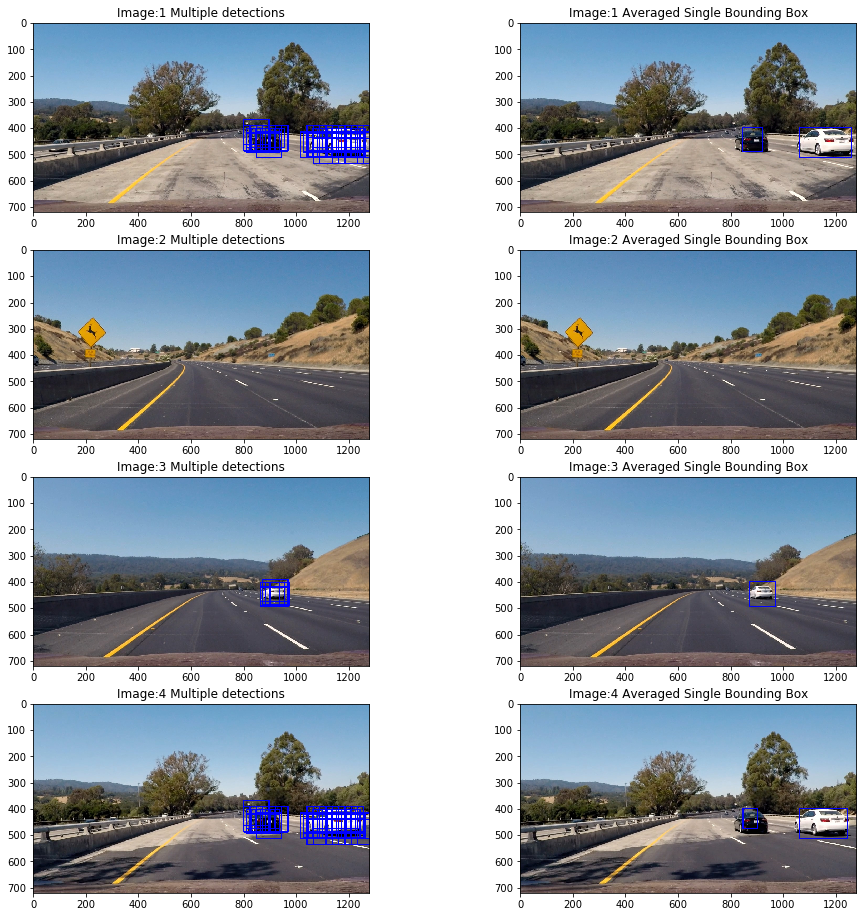

In [9]:
# Process individual image and return the heatmap and image with bounding boxes drawn
def get_processed_image(img, label_only):
    global svc, X_scaler, proc_data
    # float64 type heat map
    heat_map, dimg = find_cars(img, svc, X_scaler, proc_data["orient"],
                        proc_data["pix_per_cell"], proc_data["cell_per_block"], proc_data["inc_spatial"], 
                        proc_data["spatial"], proc_data["inc_hist"], proc_data["hbins"], proc_data["overlap"],
                        proc_data["trained_win_size"], proc_data["windows"], draw_detections=True)
    
    # normalize the heatmap to be in range 0-255 and change data type to be uint8
    nheat_map = (heat_map/np.max(heat_map))*254
    nheat_map.astype(np.uint8)
    # remove unwanted heat by thresholding and smoothen the output using gaussian blur
    nheat_map = cool_heat(nheat_map, 80)
    nheat_map = cv2.GaussianBlur(nheat_map, (5,5), 0)
    # generate labels for hot boxes and draw them onto output image
    op = draw_labeled_bboxes(img, label(nheat_map))
    # superimpose heatmap on one corner fo output video
    if not label_only:
        mini_hm = cv2.resize(nheat_map, (360, 240))
        mini_hm = np.dstack((mini_hm, np.zeros_like(mini_hm), np.zeros_like(mini_hm)))
        op[0:240, op.shape[1]-360:op.shape[1]] = mini_hm
    return op, dimg

# Load the saved model and scaler
svc = joblib.load('svm_model.pkl')
X_scaler = joblib.load('svm_scaler.pkl')

hot_frames = []
frames_sum = None
images = []
fig = plt.figure(figsize=(16, 16))
for i in range(0, 4):
    img = cv2.imread('./test_images/test'+str(i+1)+'.jpg')
    img = cv2.resize(img, (1280, 720))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    op, mdt_img = get_processed_image(img, True)
    fig.add_subplot(4, 2, (i*2)+1)
    plt.title("Image:"+str(i+1)+" Multiple detections")
    plt.imshow(mdt_img)
    fig.add_subplot(4, 2, (i*2)+2)
    plt.title("Image:"+str(i+1)+" Averaged Single Bounding Box")
    plt.imshow(op)
plt.show()

## Video Pipeline

Entire portion of the pipeline for video is same as for individual images, except for the calling function `get_processed_frame`, which is defined in `vehicleScan.py`.

Calling sequence for functions is the following:
    - get_processed_frame:
        - find_cars
            - get_predictions
        - cool_heat
        - draw_labeled_bboxes
Source code is present in following files:
    - mylib.py
    - vehicleScan.py

In [ ]:
# Create output video
hot_frames = []
frames_sum = None

print("Generating Output video")
t0 = time.time()
output_clip = in_clip.fl_image(get_processed_frame)
output_clip.write_videofile(output_vid, audio=False)
t1 = time.time()
print("Video Created in ",round((t1-t0), 2),"seconds.")